![UTFSM](https://github.com/tclaudioe/Scientific-Computing-V3/blob/main/images/Departamento%20de%20Inform%C3%A1tica%20cromatica%20negra%404x-8.png?raw=true)
# INF-285 - Computación Científica
## Gaussian Elimination, LU and PALU
## Version: 1.07

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tclaudioe/Scientific-Computing-V3/blob/main/Bonus%20-%20current/Bonus%20-%2004%20-%20GE%2C%20LU%20and%20PALU.ipynb)

<a id="toc"></a>

## Table of Contents
* [Introduction](#introduction)
* [GE](#ge)
    * [Row Operations](#rowope)
    * [Solving a linear system of equations with GE](#solvingwithge)
* [From GE to LU](#fromGEtoLU)
* [Numerical LU factorization](#lu)
    * [Solving a linear system of equation with the Numerical LU Factorization](#luls)
* [PALU factorization](#palu)
* [Acknowledgements](#acknowledgements)
* [BONUS: Computing time for a FLOP](#bonus)

In [134]:
##########################
# CoLab requirements
# https://stackoverflow.com/questions/44210656/how-to-check-if-a-module-is-installed-in-python-and-if-not-install-it-within-t
##########################

# https://pypi.org/project/colorama/

import importlib.util
import sys
import subprocess
import os
    
# install_colab_requirements 
libraries = ['numpy', 'scipy', 'matplotlib', 'colorama', 
            'bitstring', 'sympy', 'ipywidgets','pandas']

for library in libraries:
    # Check if the library is already installed
    if importlib.util.find_spec(library) is not None:
        print(f"{library} is already installed.")
    else:
        print(f"{library} is not installed. Installing...")
        # Install the library using pip
        subprocess.check_call([sys.executable, "-m", "pip", "install", library])
        print(f"{library} has been installed.")
# https://stackoverflow.com/questions/53581278/test-if-notebook-is-running-on-google-colab
if os.getenv("COLAB_RELEASE_TAG"):
    print('Installing LaTeX support in CoLab')
    # Adding LaTeX dependencies to CoLab: https://stackoverflow.com/questions/55746749/latex-equations-do-not-render-in-google-colaboratory-when-using-matplotlib
    !sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
else:
   print('Running on local environment')

numpy is already installed.
scipy is already installed.
matplotlib is already installed.
colorama is already installed.
bitstring is already installed.
sympy is already installed.
ipywidgets is already installed.
pandas is already installed.
Running on local environment


In [135]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import lu
import pandas as pd
%matplotlib inline
from scipy.linalg import hilbert
import sympy as sym

a11,a12,a21,a22,a13,a23,a31,a32,a33 = sym.symbols("a11,a12,a21,a22,a13,a23,a31,a32,a33")
b1,b2,b3 = sym.symbols("b1,b2,b3")
x1,x2,x3 = sym.symbols("x1,x2,x3")
u11,u12,u13,u22,u23,u33 = sym.symbols("u11,u12,u13,u22,u23,u33")
c1,c2,c3 = sym.symbols("c1,c2,c3")
l1,l2,l3 = sym.symbols("l1,l2,l3")
sym.init_printing(use_unicode=True)

from colorama import Fore, Back, Style
# https://pypi.org/project/colorama/
# conda install -c anaconda colorama
# Fore: BLACK, RED, GREEN, YELLOW, BLUE, MAGENTA, CYAN, WHITE, RESET.
# Back: BLACK, RED, GREEN, YELLOW, BLUE, MAGENTA, CYAN, WHITE, RESET.
# Style: DIM, NORMAL, BRIGHT, RESET_ALL
textBold = lambda x: Style.BRIGHT+x+Style.RESET_ALL
textBoldH = lambda x: Style.BRIGHT+x+Style.RESET_ALL

import matplotlib # type: ignore
FS = 14
matplotlib.rc('xtick', labelsize=FS)
matplotlib.rc('ytick', labelsize=FS)
plt.rcParams.update({
    'font.size': FS,
    'text.usetex': True,
    'font.family': 'sans-serif',
    'font.sans-serif': 'Helvetica',
    'text.latex.preamble': r'\usepackage{amsfonts}\usepackage{amsmath}'
})

<a id="intro"></a>

## Introduction
[Back to TOC](#toc)

In this Jupyter Notebook we will learn about Gaussian Elimination (GE), LU and PALU.

**WARNING: Please make sure you execute the cells from top to botton and avoid executing the same cell twice because you may encounter some problems. For instance, we sometimes add a column or remove a column from a matrix, so if you exceute twice that cell, it will remove or add extra columns, which may make the code fail.**

<a id="ge"></a>

# Gaussian Elimination (GE)
[Back to TOC](#toc)

The probably first algorithm that one studies to find an inverse of a matrix or to solve a linear system of equations is the Gaussian Elimination.
This algorithm has the advantage that it is more or less direct to understand.

Note that in the **classnotes** we have put _**a lot**_ of emphasis into hightlight that it is not needed to compute the inverse of a matrix to solve a linear system of equations.
Now, we will show that we don't need to compute the inverse of a matrix to solve a linear system of equations.
But before, we will review how to perform a **row** operation.

<a id="rowope"></a>

## Row operations
[Back to TOC](#toc)

The simplest case one can use a **row operation** is in a $2\times 2$ matrix, say $A=\begin{bmatrix} a_{11} & a_{12}\\ a_{21} & a_{22} \end{bmatrix}=\begin{bmatrix}
R_1 \\ R_2\end{bmatrix}$, where $R_1$ and $R_2$ represent the first and second rows, respectively.
For instance, if we want to make $0$ the first coefficient of the second row, we could perform the following row operation:
$$
R_2 = R_2-\dfrac{a_{21}}{a_{11}}\,R_1,
$$
which is interpreted as: **Multiply row $R_1$ by the coefficient $\dfrac{a_{21}}{a_{11}}$ and substract it from row $R_2$**, this implies that the row $R_2$ gets modified.

_Note: The previous expression only makes sense in a Computational context, because we are assigning a value to the left. On the other hand, this can't be interpreted as an equation, otherwise we would cancel out $R_2$, which does not make sense!_

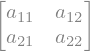

In [187]:
# We define the "symbolic" matrix "A"
A=sym.Matrix([[a11, a12], [a21, a22]])
display(A)

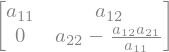

In [188]:
# We repeat the definition of "A" here to avoid errors
A=sym.Matrix([[a11, a12], [a21, a22]])
# Computing "row operation"
############################
# NOTE: This code is needed to perform the row
# operation in sympy.
R2new = A.row(1)-(a21/a11)*A.row(0)
A.row_del(1)
A = A.row_insert(1,R2new)
############################
# Showing the final output
display(A)

An alternative way to perform the row operation is by doing it with a matrix-matrix multiplication, this means,

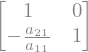

In [189]:
# We repeat the definition of "A" here to avoid errors
A=sym.Matrix([[a11, a12], [a21, a22]])
# Note that the matrix Lij correspond the "row operation" to
# make zero the coefficient at Aij, where we start
# indexing the rows and columns from 0.
# NOTE: This notation is used in the "classnotes".
L10 = sym.Matrix([[1, 0], [-a21/a11, 1]])
display(L10)

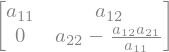

In [190]:
# Performing the *row* operation and showing the outcome
A=sym.Matrix([[a11, a12], [a21, a22]]) # Repeting the definition to avoid errors
A = L10*A
display(A)

In general, the same procedure applies for larger matrices, for instance, for a $3\times 3$ matrix.
Let's take a look to it.

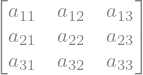

In [191]:
A=sym.Matrix([[a11, a12, a13], [a21, a22, a23], [a31, a32, a33]])
display(A)

Now, let us compute the first two **row** operations a make zero the first coefficient of the second and third row.

L10:


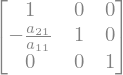

L20:


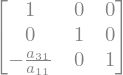

We see now that the first coefficients for the second and third row are 0


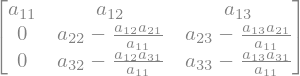

In [192]:
A=sym.Matrix([[a11, a12, a13], [a21, a22, a23], [a31, a32, a33]])
L10 = sym.eye(3)
L10[1,0] = -a21/a11
print(textBoldH('L10:'))
display(L10)
L20 = sym.eye(3)
L20[2,0] = -a31/a11
print(textBoldH('L20:'))
display(L20)

# Applying the "row" operations
A = L20*L10*A
print(textBoldH('We see now that the first coefficients for the second and third row are 0'))
display(A)

Now, it only remains to make $0$ the third coefficient of the second column.
**It is important to highlight that we can't define in advance the matrix $L_{2,1}$ since we don't know the coefficients we will get for the second and third rows of the second column.**
Therefore, now that we know the coefficients, we can build the corresponding **row operation** as follows,

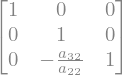

In [203]:
L21 = sym.eye(3)
L21[2,1] = -A[2,1]/A[1,1] # type: ignore
display(L21)

Now, we compute the product.
**Notice that the cells involved in this computation need to be executed in order, if they are ejecuted twice for instance, they will apply the computation twice and this may induce an unintended behavior**.

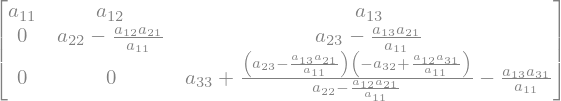

In [194]:
A=L21*A
display(A)

Finally, we can conclude that the **row operations** used helped us to make the original matrix $A$ into its **upper triangular** form!

<a id="solvingwithge"></a>

## Solving a linear system of equations with GE
[Back to TOC](#toc)

In this case, consider we have the following linear system of equations:
$$
\underbrace{\begin{bmatrix}
    a_{11} & a_{12} & a_{13}\\
    a_{21} & a_{22} & a_{23}\\
    a_{31} & a_{32} & a_{33}
\end{bmatrix}}_{\displaystyle{A}}
\underbrace{\begin{bmatrix}
    x_1\\
    x_2\\
    x_3
\end{bmatrix}}_{\displaystyle{\mathbf{x}}}
=
\underbrace{\begin{bmatrix}
    b_1\\
    b_2\\
    b_3
\end{bmatrix}}_{\displaystyle{\mathbf{b}}}.
$$

Or in explicit form,

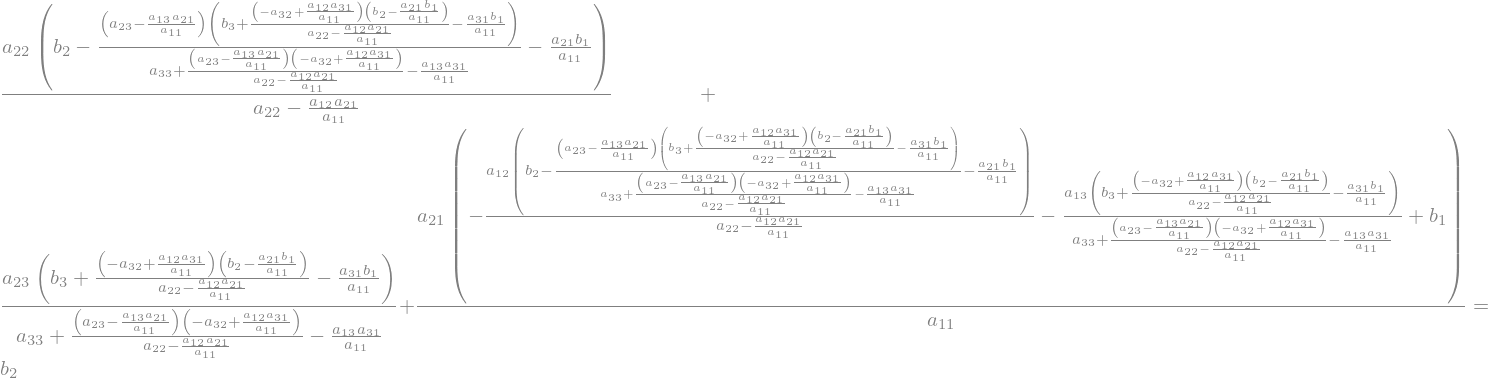

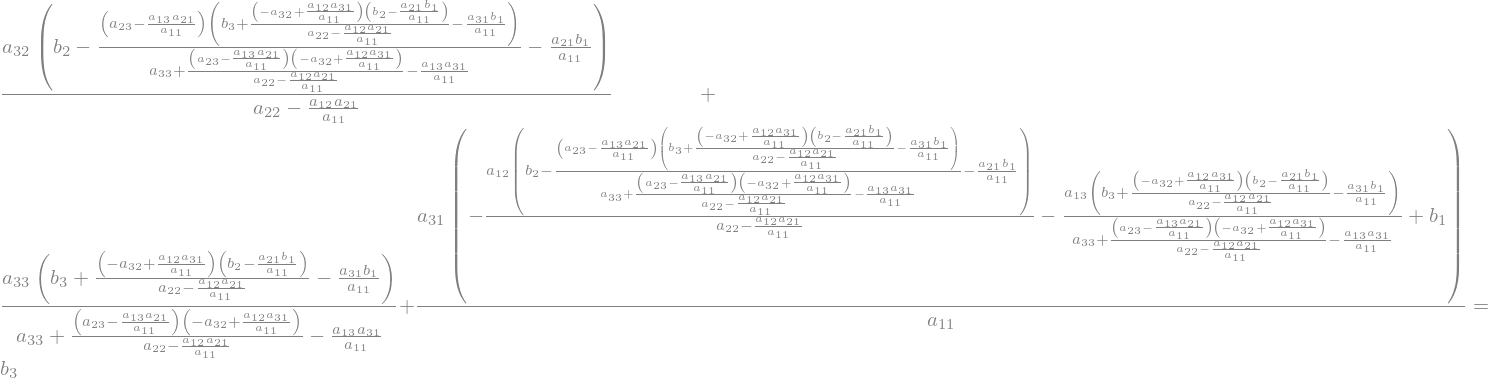

In [195]:
A = sym.Matrix([[a11, a12, a13], [a21, a22, a23], [a31, a32, a33]])
b = sym.Matrix([[b1],[b2],[b3]])
display(sym.Eq(A[0,0] * x1 + A[0,1] * x2 + A[0,2] * x3, b[0]))
display(sym.Eq(A[1,0] * x1 + A[1,1] * x2 + A[1,2] * x3, b[1]))
display(sym.Eq(A[2,0] * x1 + A[2,1] * x2 + A[2,2] * x3, b[2]))

Thus, the procedure we will use is the following:
1. Build the _Tableu_ $B=[A|\mathbf{b}]$.
2. Apply **row operations** to make the _Tableu_ **upper triangular**.
3. Solve the **NEW** and **EQUIVALENT** linear system of equations, $U\,\mathbf{x}=\mathbf{c}$, using the algorithm _Backward Substitution_.

To make this explicit, we will perform all steps for the $3\times 3$ linear system of equations previously presented.

<a id="solvingWithGEStep1"></a>

### STEP 1
Building the Tableu

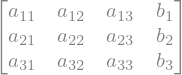

In [196]:
A = sym.Matrix([[a11, a12, a13], [a21, a22, a23], [a31, a32, a33]])
b = sym.Matrix([[b1],[b2],[b3]])
B = A.col_insert(3,b)
# The "Tableu"
display(B)

<a id="solvingWithGEStep2"></a>

### STEP 2
Applying **row operations**

Canceling out the elements below the diagonal coefficient of first column


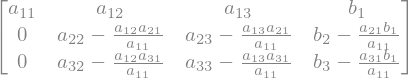

Finally, canceling out the only element below the diagonal of the second column


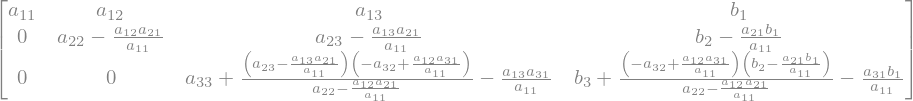

In [197]:
# Row operations for first column
L10 = sym.eye(3)
L10[1,0] = -a21/a11
L20 = sym.eye(3)
L20[2,0] = -a31/a11
# Applying the "row" operations for first column
B = L20*L10*B
print(textBoldH('Canceling out the elements below the diagonal coefficient of first column'))
display(B)

# Row operation for second column
L21 = sym.eye(3)
L21[2,1] = -B[2,1]/B[1,1]
# Applying the "row" operation for second column
B=L21*B
print(textBoldH('Finally, canceling out the only element below the diagonal of the second column'))
display(B)

<a id="solvingWithGEStep3"></a>

### STEP 3
Build the equivalent linear system of equations and solve it with _Backward Substitution_.

The RHS $\mathbf{c}$


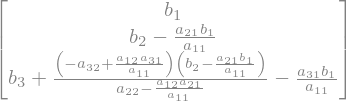

The upper triangular matrix U


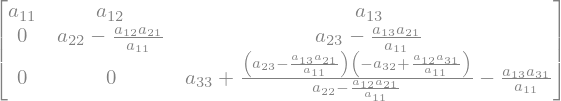

In [198]:
c = B.col(3)
print(textBoldH(r'The RHS $\mathbf{c}$'))
display(c)
B.col_del(3)
U = B
print(textBoldH('The upper triangular matrix U'))
display(U)

Now we have,
$$
U\,\mathbf{x} = \mathbf{c}.
$$
Thus, we can now apply _Backward Substitution_, give the **upper triangular** form of the matrix $U$.
Now, for completeness, we will show the three equation we have,

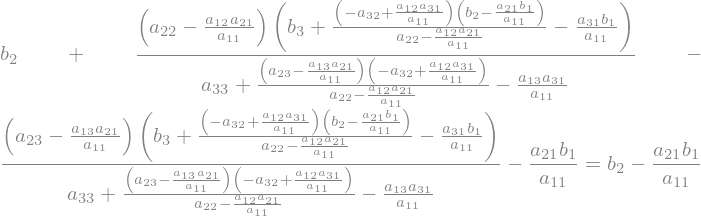

In [199]:
display(sym.Eq(U[0,0] * x1 + U[0,1] * x2 + U[0,2] * x3, c[0]))
display(sym.Eq(U[1,1] * x2 + U[1,1] * x3, c[1]))
display(sym.Eq(U[2,2] * x3, c[2]))


It may be harder to see, but the last equation is the simplest one to solve.
**Note that the 'formula' shown on the coefficients just represent a number, so it may be easier to see in the following form:**

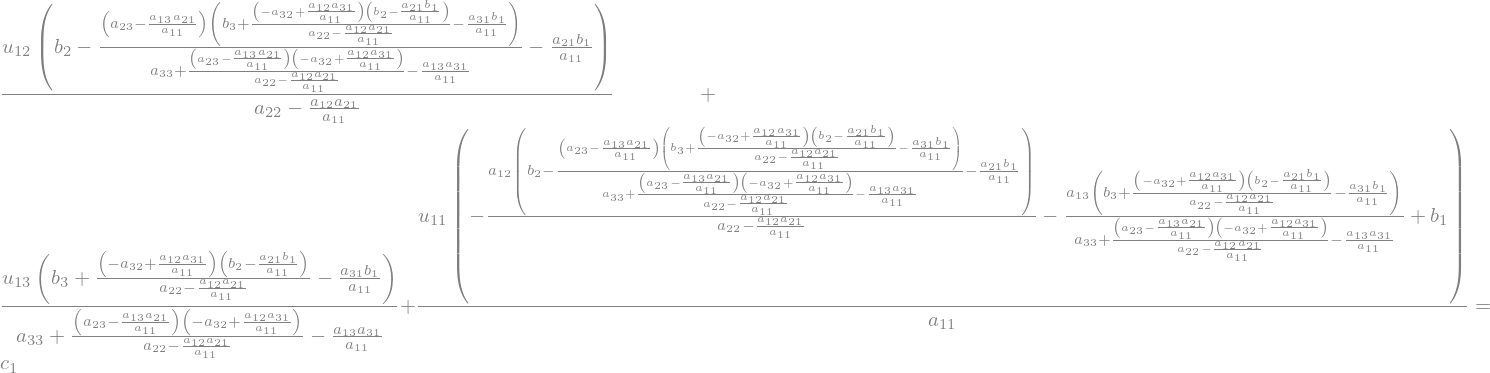

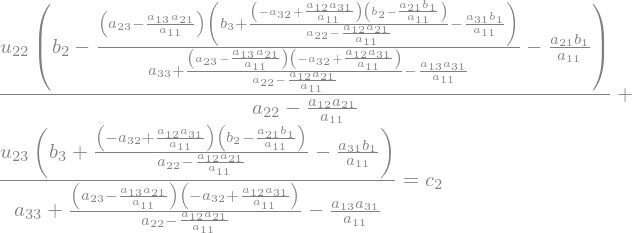

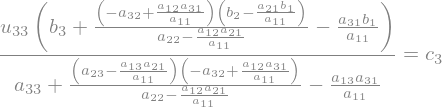

In [200]:
display(sym.Eq(u11 * x1 + u12 * x2 + u13 * x3, c1))
display(sym.Eq(u22 * x2 + u23 * x3, c2))
display(sym.Eq(u33 * x3, c3))

Now, we clearly see that the simplest equation to solve is indeed the last one!

We now solve the _transformed_ linear system of equations then:

x3


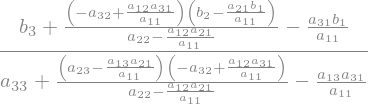

x2


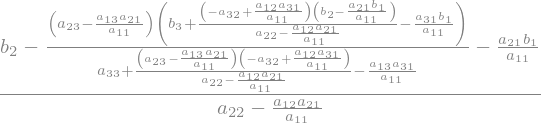

x1


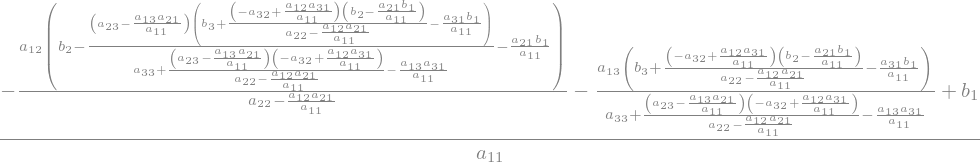

In [201]:
# Backward substitution - here we solve the last equation, in this case the third equation. We show it for completeness: 
x3 = c[2]/U[2,2]
print(textBoldH('x3'))
display(x3)
x2 = (c[1]-U[1,2]*x3)/U[1,1]
print(textBoldH('x2'))
display(x2)
x1 = (c[0]-U[0,1]*x2-U[0,2]*x3)/U[0,0]
print(textBoldH('x1'))
display(x1)

**For completeness, we will check with SymPy that what we found actually solves the original linear system of equations:**

In [202]:
display(sym.Eq(sym.simplify(A[0,0] * x1 + A[0,1] * x2 + A[0,2] * x3), b[0]))
display(sym.Eq(sym.simplify(A[1,0] * x1 + A[1,1] * x2 + A[1,2] * x3), b[1]))
display(sym.Eq(sym.simplify(A[2,0] * x1 + A[2,1] * x2 + A[2,2] * x3), b[2]))

**Therefore, since all the outcomes are _True_, it does solve the original linear system of equations!**

What we have learnt here?

**Advantages**:
1. _Transforming_ the linear system of equation $A\,\mathbf{x}=\mathbf{b}$ to $U\,\mathbf{x}=\mathbf{c}$ by means of row operations, it does indeed gives an **algorithm** to solve a linear system of equations.

**Disadvantages**
1. If we need to solve another linear system of equations where the only difference is the RHS vector, i.e. we get $A\,\mathbf{x}=\widetilde{\mathbf{b}}$, we still need to perform all the row operation, this implies that we will get the same matrix $U$ and the only change will be on the RHS, because we will get $\widetilde{\mathbf{c}}$. This, actually, tells us that there is something we could take advantage of. This is what the _LU_ factorization does!
2. _There is another disadvantage that will be solved by the PALU factorization later, we ommit it for now_.

**Comments**
- The symbolic approach performed before, it is of limited use for larger linear system of equations. But it has, hopefully, been useful for understanding the Gaussian Elimination!

<a id="fromgetolu"></a>

# From GE to LU
[Back to TOC](#toc)

The main _disadvantage_ of GE is that it needs to be computed completely from zero for each linear system of equations.
Thus, we will study now how the GE is actually more powerful, and it can produce the LU factorization of a matrix.
This means, to be able to rewrite a matrix $A$ as a product of the matrices $L$ and $U$, in general for a $n\times n$ matrix this takes the following form,
$$
\begin{bmatrix}
    a_{1,1} & a_{1,2} & a_{1,3} & \cdots & a_{1,n} \\
    a_{2,1} & a_{2,2} & a_{2,3} & \ddots & a_{2,n} \\
    a_{3,1} & a_{3,2} & a_{3,3} & \ddots & a_{3,n} \\
    \vdots & & \ddots  & \ddots & \vdots \\
    a_{n,1} & a_{n,2} & \cdots & \cdots & a_{n,n} 
\end{bmatrix}
=
\begin{bmatrix}
    1 & 0 & \cdots & \cdots & 0 \\
    l_{2,1} & 1 & \ddots & \ddots & 0 \\
    l_{3,1} & l_{3,2} & 1 & \ddots & 0 \\
    \vdots & & \ddots & \ddots &\vdots  \\
    l_{n,1} & \cdots & \cdots & l_{n,n-1} & 1
\end{bmatrix}
\begin{bmatrix}
    u_{1,1} & u_{1,2} & u_{1,3} & \cdots & u_{1,n} \\
    0 & u_{2,2} & u_{2,3} & \ddots & u_{2,n} \\
    0 & 0 & u_{3,3} & \ddots & u_{3,n} \\
    \vdots & & \ddots  & \ddots & \vdots \\
    0 & 0 & \cdots & 0 & u_{n,n} 
\end{bmatrix}.$$

We note right away that the matrices $L$ and $U$ are **lower triangular** and **upper triangular** matrices, respectively.
Moreover, the diagonal of $L$ are only $1$'s.

In particular, we will use _again_ a $3\times 3$ example, i.e.
$$
\begin{bmatrix}
    a_{1,1} & a_{1,2} & a_{1,3} \\
    a_{2,1} & a_{2,2} & a_{2,3} \\
    a_{3,1} & a_{3,2} & a_{3,3} 
\end{bmatrix}
=
\begin{bmatrix}
    1 & 0 &  0 \\
    l_{2,1} & 1 & 0 \\
    l_{3,1} & l_{3,2} & 1
\end{bmatrix}
\begin{bmatrix}
    u_{1,1} & u_{1,2} & u_{1,3}\\
    0 & u_{2,2} & u_{2,3}\\
    0 & 0 & u_{3,3}
\end{bmatrix}.$$


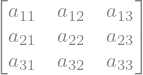

In [152]:
A = sym.Matrix([[a11, a12, a13], [a21, a22, a23], [a31, a32, a33]])
display(A)

As we did before, the first two row operation can be expressed as a matrix-matrix product with $L_1=L_{1,0}(-\frac{a_{2,1}}{a_{1,1}})$ and $L_2=L_{1,0}(-\frac{a_{3,1}}{a_{1,1}})$, respectively.
And, 

_A more detailed explanation of the use of the matrices $L_{i,j}(c)$ is presented in the classnotes, please take a look at them_.

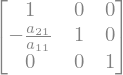

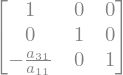

In [153]:
# Row operations for first column
L10 = sym.eye(3)
L10[1,0] = -a21/a11
L1 = L10
display(L1)
L20 = sym.eye(3)
L20[2,0] = -a31/a11
L2 = L20
display(L2)

To compute the third, and last, row operation as a matrix-matrix product, we need to apply the first two row operations.
After applying them, we can get the _updated_ coefficient of the diagonal of the second column, $A[1,1]$, needed to cancel out the _updated_ coefficient, $A[2,1]$, of the 3rd row and 2nd column.
Now,we can build $L_3=L_{2,1}(-A[2,1]/A[1,1])$.

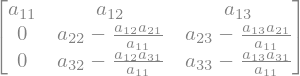

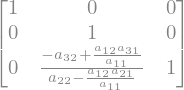

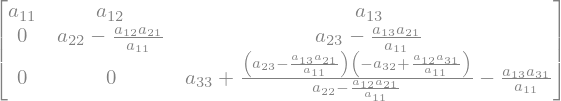

In [154]:
A = sym.Matrix([[a11, a12, a13], [a21, a22, a23], [a31, a32, a33]])
A = L2*L1*A
display(A)
L21 = sym.eye(3)
L21[2,1] = -A[2,1]/A[1,1]
L3 = L21
display(L3)
U = L3*A
display(U)

Thus, we have sucessfully computed $L_1$, $L_2$, and $L_3$.
This actually show we have the following identity,
$$
L_3\,L_2\,L_1\,A=U.
$$
To verify it, we do it with SymPy,

In [155]:
A = sym.Matrix([[a11, a12, a13], [a21, a22, a23], [a31, a32, a33]])
sym.Eq(sym.simplify(L3*L2*L1*A),sym.simplify(U))

This output equal to _True_ shows that the identity holds!

Now, we are one step closer to the _LU_ factorization.
We may notice that $L$ should be conencted to the matrices $L_1$, $L_2$ and $L_3$.
But, before we continue we need to point out a property of the $L_k$ matrices.
This is that the computation of the inverse of each of them is very simply, it is just the same matrix but with the opposite sign in the coefficient used for the row operation.
In particular, as we defined before, if we write the _row-operation matrices_ as $L_{i,j}(c)$, then its inverse is simply $L_{i,j}(-c)$.
For instace, let's considerr $L_1$.


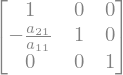

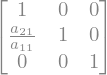

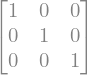

In [156]:
display(L1)
display(L1.inv())
display(L1*L1.inv())

This allow us to move to the RHS the matrices $L_1$, $L_2$ and $L_3$ in the identity $L_3\,L_2\,L_1\,A=U$ as follows,
$$
A = L_1^{-1}\,L_2^{-1}\,L_3^{-1}\,U.
$$
In particular, if we re-write $L_1$, $L_2$ and $L_3$ as follows,
$$
L_1=
\begin{bmatrix}
    1 & 0 & 0\\
    -l_1 & 1 & 0\\
    0 & 0 & 1
\end{bmatrix},
\quad
L_2=
\begin{bmatrix}
    1 & 0 & 0\\
    0 & 1 & 0\\
    -l_2 & 0 & 1
\end{bmatrix},
\quad
\textrm{and}
\quad
L_3=
\begin{bmatrix}
    1 & 0 & 0\\
    0 & 1 & 0\\
    0 & -l_3 & 1
\end{bmatrix}.
$$

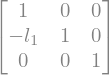

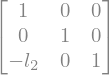

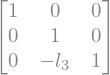

In [157]:
L1 = sym.Matrix([[1,0,0],[-l1,1,0],[0,0,1]])
L2 = sym.Matrix([[1,0,0],[0,1,0],[-l2,0,1]])
L3 = sym.Matrix([[1,0,0],[0,1,0],[0,-l3,1]])
display(L1,L2,L3)

Compute the inverse of each one explicitly, we notice the property mentioend before, i.e. $L_{i,j}^{-1}(c)=L_{i,j}(-c)$.

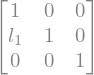

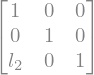

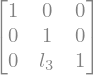

In [158]:
display(L1.inv())
display(L2.inv())
display(L3.inv())

Another important property of this $L_{i,j}(c)$ matrices is that if we multiply them in the actual order we showed before we get the following identity,
$$
\begin{align*}
\begin{bmatrix}
    1 & 0 & 0\\
    -l_1 & 1 & 0\\
    0 & 0 & 1
\end{bmatrix}^{-1}
\begin{bmatrix}
    1 & 0 & 0\\
    0 & 1 & 0\\
    -l_2 & 0 & 1
\end{bmatrix}^{-1}
\begin{bmatrix}
    1 & 0 & 0\\
    0 & 1 & 0\\
    0 & -l_3 & 1
\end{bmatrix}^{-1}
&=
\begin{bmatrix}
    1 & 0 & 0\\
    l_1 & 1 & 0\\
    0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
    1 & 0 & 0\\
    0 & 1 & 0\\
    l_2 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
    1 & 0 & 0\\
    0 & 1 & 0\\
    0 & l_3 & 1
\end{bmatrix}\\
&=
\begin{bmatrix}
    1 & 0 & 0\\
    l_1 & 1 & 0\\
    l_2 & l_3 & 1
\end{bmatrix}
\end{align*}.
$$

This means that the product $L_1^{-1}\,L_2^{-1}\,L_3^{-1}$ actually collects the coefficients of the corresponding component, without changing anything else.

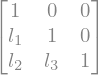

In [159]:
display(L1.inv()*L2.inv()*L3.inv())

**This is wonderful! Since it actually gives the WANTED matrix $L$**.

We can verify this now con SymPy again, but using the $3\times 3$ original matrix with coefficients,

L


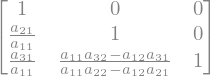

U


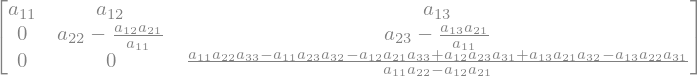

Product of $L\,U$ which should be $A$


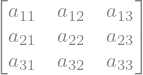

In [160]:
# L1
L10 = sym.eye(3)
L10[1,0] = -a21/a11
L1 = L10
# L2
L20 = sym.eye(3)
L20[2,0] = -a31/a11
L2 = L20
# L3
A = sym.Matrix([[a11, a12, a13], [a21, a22, a23], [a31, a32, a33]])
A = L2*L1*A
L21 = sym.eye(3)
L21[2,1] = -A[2,1]/A[1,1]
L3 = L21
U = L3*A
L = L1.inv()*L2.inv()*L3.inv()
print(textBoldH('L'))
display(sym.simplify(L))
print(textBoldH('U'))
display(sym.simplify(U))
print(textBoldH(r'Product of $L\,U$ which should be $A$'))
display(sym.simplify(L*U))

**We have then successfully built the _LU_ factorization!**.

**SUMMARY:**
1. The computation of the $U$ matrix is exactly the same procedure used in GE.
2. The computation of the $L$ matrix only requires to store the negative of the coefficients used for the row-operations, so, it does not requiere additional computation, it only requires to _store_ the coefficient at each step.

Now, all the analysis have been done with SymPy, however we need to do it numerically to scale for larger matrices.
This will be performed on the next section.

<a id="lu"></a>


# Numerical LU factorization
[Back to TOC](#toc)

Let $A \in \mathbb{R}^{n \times n}$ be a square and non-singular matrix.
We plan now to build the _LU_ factorization of $A$ such that $A = L\,U$ where $L,U \in \mathbb{R}^{n \times n}$ are lower and upper triangular matrices respectively.
For completeness, we show them explicitly here again,
$$\begin{bmatrix}
    a_{1,1} & a_{1,2} & a_{1,3} & \cdots & a_{1,n} \\
    a_{2,1} & a_{2,2} & a_{2,3} & \ddots & a_{2,n} \\
    a_{3,1} & a_{3,2} & a_{3,3} & \ddots & a_{3,n} \\
    \vdots & & \ddots  & \ddots & \vdots \\
    a_{n,1} & a_{n,2} & \cdots & \cdots & a_{n,n} 
\end{bmatrix}
=
\begin{bmatrix}
    1 & 0 & \cdots & \cdots & 0 \\
    l_{2,1} & 1 & \ddots & \ddots & 0 \\
    l_{3,1} & l_{3,2} & 1 & \ddots & 0 \\
    \vdots & & \ddots & \ddots &\vdots  \\
    l_{n,1} & \cdots & \cdots & l_{n,n-1} & 1
\end{bmatrix}
\begin{bmatrix}
    u_{1,1} & u_{1,2} & u_{1,3} & \cdots & u_{1,n} \\
    0 & u_{2,2} & u_{2,3} & \ddots & u_{2,n} \\
    0 & 0 & u_{3,3} & \ddots & u_{3,n} \\
    \vdots & & \ddots  & \ddots & \vdots \\
    0 & 0 & \cdots & 0 & u_{n,n} 
\end{bmatrix}$$

The main difference between a _symbolic computation_ and a _numerical computation_ for the _LU_ factorization is that at each step of the _numerical computation_ we apply the algorithm over numerical values of the matrices used and when we do the **pivoting**, i.e. the row operation, we actually compute the values required and we don't _store_ the **formulas** as we do in the symbolic computation.

We next code shows is a _academic_ implementation of the _GE_ for the _LU_ factorization, this means it purpose is to show the steps and it it not performance.
Most of the idea has been explained before, so here we focus directly on the implementation and some numerical examples.

In [161]:
'''
LU factorization
Input:
    A                   : (ndarray) Input matrix of nxn
    show=False          : (bool) Bool variable to define if showing or not intermediate steps
    print_precision=2   : (int) Number of decimals to be used when showing intermediate steps
Output:
    L   : (ndarray) Output matrix L of LU factorization
    U   : (ndarray) Output matrix U of LU factorization
'''
def lu_factorization(A, show=False, print_precision=2):
    n,_ = A.shape
    U = np.copy(A)
    L = np.identity(n)
    if show:
        print(textBold('Initial matrices'))
        print('L = '); print(np.array_str(L, precision=print_precision, suppress_small=True))
        print('U = '); print(np.array_str(U, precision=print_precision, suppress_small=True))
        print('----------------------------------------')
    # Iterating through columns
    for j in range(n-1):
        # Iterating through rows
        for i in range(j+1,n):
            # STORING the coefficient with opposite sign
            L[i,j] = U[i,j]/U[j,j]
            # Applying the 'row-operation' with the negative sign.
            # Notice that this is a 'vectorize' operation since U[i,j:] and U[j,j:] are vectors. 
            U[i,j:] -= L[i,j]*U[j,j:]
            if show:
                print(textBoldH(f'Cancelling out coefficient ({i},{j})'))
                print('L = '); print(np.array_str(L, precision=print_precision, suppress_small=True))
                print('U = '); print(np.array_str(U, precision=print_precision, suppress_small=True))
                print('----------------------------------------')
    return L,U

We show in the next example a $3\times 3$ example.

In [162]:
# YOU CAN TRY WITH A LARGER VALUE OF 'n' AND SEE WHAT HAPPENDS!
n = 3
# Fixing the 'seed' of the random number generator to obtain reproducible outcomes.
rng = np.random.Generator(np.random.PCG64(seed=0))
A = rng.standard_normal((n,n))
L, U = lu_factorization(A, show=True)

Initial matrices
L = 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
U = 
[[ 0.13 -0.13  0.64]
 [ 0.1  -0.54  0.36]
 [ 1.3   0.95 -0.7 ]]
----------------------------------------
Cancelling out coefficient (1,0)
L = 
[[1.   0.   0.  ]
 [0.83 1.   0.  ]
 [0.   0.   1.  ]]
U = 
[[ 0.13 -0.13  0.64]
 [ 0.   -0.43 -0.17]
 [ 1.3   0.95 -0.7 ]]
----------------------------------------
Cancelling out coefficient (2,0)
L = 
[[ 1.    0.    0.  ]
 [ 0.83  1.    0.  ]
 [10.37  0.    1.  ]]
U = 
[[ 0.13 -0.13  0.64]
 [ 0.   -0.43 -0.17]
 [ 0.    2.32 -7.35]]
----------------------------------------
Cancelling out coefficient (2,1)
L = 
[[ 1.    0.    0.  ]
 [ 0.83  1.    0.  ]
 [10.37 -5.45  1.  ]]
U = 
[[ 0.13 -0.13  0.64]
 [ 0.   -0.43 -0.17]
 [ 0.    0.   -8.29]]
----------------------------------------


Now, we compute the difference between the product $L\,U$ and $A$, which should generate the zero-matriz, since they should be the same.

In [163]:
print((L@U)-A)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -3.33066907e-16 -8.88178420e-16]]


The outcome are _numerically_ equal!
This is what was expected. 

- **Why do we get _small coefficients_ in the matrix?**

<a id="luls"></a>

## Solving a linear system of equation with the Numerical LU Factorization
[Back to TOC](#toc)

For solving a linear system of equations, say $A\,\mathbf{x} = \mathbf{b}$, we need to perform the following steps:

1. Compute the _LU_ factorization of $A$, such that $A=L\,U$.
2. Solve for $\mathbf{c}$: $L\,\mathbf{c}=\mathbf{b}$, with _Forward Substitution_.
3. Solve for $\mathbf{x}$: $U\,\mathbf{x}=\mathbf{c}$, with _Backward Subtitution_.

Done, $\mathbf{x}$ has been found!

These steps come from the following analysis:
$$
\begin{align*}
    A\,\mathbf{x} &= \mathbf{b}. \quad \textrm{Original problem,}\\
    L\,U\,\mathbf{x} &= \mathbf{b}. \quad \textrm{Replacing $A=L\,U$. \textbf{Step ``1''}.}\\
    L\,\underbrace{U\,\mathbf{x}}_{\displaystyle\mathbf{c}} &= \mathbf{b}. \quad \textrm{Defining intermediate unknown vector $\mathbf{c}$.}\\
    L\,\mathbf{c} &= \mathbf{b}. \quad \textrm{Solve for $\mathbf{c}$ with \textit{Forward Substitution}. \textbf{Step ``2''}.}\\
    U\,\mathbf{x} &= \mathbf{c}. \quad \textrm{From definition of the intermediate unknown vector $\mathbf{c}$ we have this equation.}\\
    U\,\mathbf{x} &= \mathbf{c}. \quad \textrm{Solve for $\mathbf{x}$ with \textit{Backward Substitution}. \textbf{Step ``3''}.}\\
\end{align*}
$$

To be more explicit, we write down the intermediate linear system that need to be solve, i.e. $L\,\mathbf{c} = \mathbf{b}$ and $U\,\mathbf{x} = \mathbf{c}$,
$$
\begin{align*}
    L\,\mathbf{c}&= \mathbf{b}\\
\underbrace{\begin{bmatrix}
    1 & 0 & \cdots & \cdots & 0 \\
    l_{2,1} & 1 & \ddots & \ddots & 0 \\
    l_{3,1} & l_{3,2} & 1 & \ddots & 0 \\
    \vdots & & \ddots & \ddots &\vdots  \\
    l_{n,1} & \cdots & \cdots & l_{n,n-1} & 1
\end{bmatrix}}_{\displaystyle{L}}
\underbrace{\begin{bmatrix}
    c_1 \\
    c_2 \\
    c_3 \\
    \vdots \\
    c_{n-1} \\
    c_n
\end{bmatrix}}_{\displaystyle{\mathbf{c}}}
&=
\underbrace{\begin{bmatrix}
    b_1 \\
    b_2 \\
    b_3 \\
    \vdots \\
    b_{n-1} \\
    b_n
\end{bmatrix}}_{\displaystyle{\mathbf{b}}}.
\end{align*}$$
and
$$
\begin{align*}
    U\,\mathbf{x}&= \mathbf{c}\\
\underbrace{\begin{bmatrix}
    u_{1,1} & u_{1,2} & u_{1,3} & \cdots & u_{1,n} \\
    0 & u_{2,2} & u_{2,3} & \ddots & u_{2,n} \\
    0 & 0 & u_{3,3} & \ddots & u_{3,n} \\
    \vdots & & \ddots  & \ddots & \vdots \\
    0 & 0 & \cdots & 0 & u_{n,n} 
\end{bmatrix}}_{\displaystyle{U}}
\underbrace{\begin{bmatrix}
    x_1\\
    x_2\\
    x_3\\
    \vdots\\
    x_{n-1}\\
    x_n
\end{bmatrix}}_{\displaystyle{\mathbf{x}}}
&=
\underbrace{\begin{bmatrix}
    c_1\\
    c_2\\
    c_3\\
    \vdots\\
    c_{n-1}\\
    c_n
\end{bmatrix}}_{\displaystyle{\mathbf{c}}}
\end{align*}.$$

From which we can easily see that to solve $L\,\mathbf{c} = \mathbf{b}$ by _Forward substitution_ means that we solve the **first equation**, we get $c_1$, then since we know $c_1$ we consider the second equation and we obtain $c_2$, and so on.
This makes solving this linear system of equation very easily!
Similarly, we can solve $U\,\mathbf{x} = \mathbf{c}$, but instead of starting from the first equation we start from the **last equation**, which allows us to obtain $x_n$, and then we replace $x_n$ in the before last equation to get $x_{n-1}$, and so on.
It is also very easily solved.

Therefore, having the _LU_ factorization of the matrix $A$ is very useful.

The next code implements the _Forward_ and _Backward_ substitutions:

In [164]:
'''
Solves a linear system A x = b, where A is a
triangular (upper or lower) matrix.

Input:
    A           : (ndarray) Input "upper" or "lower" triangular matrix.
    b           : (ndarray) RHS
    upper=True  : (Bool) If True, it considers the matrix A is "upper" triangular and performs "Backward substitution",
                            else, it considers the matrix A is "lower" triangular and performs "Forward substitution".
Outout:
    x : (ndarray) It returns the numerical solution of 'A x=b'

'''
def solve_triangular(A, b, upper=True):
    n = b.shape[0]
    x = np.zeros_like(b)
    if upper==True:
        # Backward-substitution
        x[-1] = (1./A[-1,-1]) * b[-1]
        for i in range(n-2, -1, -1):
            x[i] = (1./A[i,i]) * (b[i] - np.dot(A[i,i+1:],x[i+1:]))
    else:
        # Forward-substitution
        x[0] = (1./A[0,0]) * b[0]
        for i in range(1,n):
            x[i] = (1./A[i,i]) * (b[i] - np.dot(A[i,:i],x[:i]))
    return x

Now, we have implemented the _Forward_ and _Backward_ substitutions, we can solve a linear system of equations for larger problems! 
For doing this, we implement the following _solver_,

In [165]:
'''
This code solves a linear system of equations Ax=b using the LU factorization

Input:
    A                   : (ndarray) Input matrix 'A'.
    b                   : (ndarray) RHS
    show=False          : (bool) Boolean variable to show interrmediate steps of LU factorization
    print_precision=2   : (int) Number of decimals to show when showing intermediate steps in the LU factorization
    
Output:
    x : (ndarray) It returns the numerical solution of 'A x=b'
'''
def solve_lu(A, b, show=False, print_precision=2):
    # STEP 1: Computing the LU factorization
    L,U = lu_factorization(A, show=show, print_precision=print_precision)
    # L.c = b with c = U.x
    # STEP 2:
    c = solve_triangular(L, b, upper=False)
    # STEP 3:
    x = solve_triangular(U, c)
    return x

Let's now try our implementations. We begin by creating a random $3 \times 3$ linear system:

In [166]:
n = 10
# Fixing the 'seed' of the random number generator to obtain reproducible outcomes.
rng = np.random.Generator(np.random.PCG64(seed=0))
A = rng.standard_normal((n,n))
x_exact = rng.standard_normal(n)
# We do this here so we can compare later the numerical solution
# with what we should have obtained.
b = np.dot(A,x_exact)

# Solving Ax=b with LU
x_lu_sol = solve_lu(A,b)

# Solving Ax=b with NumPy
x_np_sol = np.linalg.solve(A,b)

print(textBoldH('Exact solution'))
print(x_exact)
print(textBoldH('Numerical solution with LU factorization'))
print(x_lu_sol)
print(textBoldH('Numerical solution with NumPy solver'))
print(x_np_sol)

print(textBoldH('\n To make the comparison better, we compute the norms of the difference for each case:'))
print(textBold('||x_lu_sol-x_exact||_2='),np.linalg.norm(x_lu_sol-x_exact))
print(textBold('||x_np_sol-x_exact||_2='),np.linalg.norm(x_np_sol-x_exact))
print(textBoldH('and for completeness, we compare the norm between the approximations'))
print(textBold('||x_np_sol-x_lu_sol||_2='),np.linalg.norm(x_np_sol-x_lu_sol))

Exact solution
[ 0.50268285  0.98971303 -0.16429459 -1.07436486  0.87304215 -1.28039394
 -0.7130681   0.62101785 -2.25014117  0.3863696 ]
Numerical solution with LU factorization
[ 0.50268285  0.98971303 -0.16429459 -1.07436486  0.87304215 -1.28039394
 -0.7130681   0.62101785 -2.25014117  0.3863696 ]
Numerical solution with NumPy solver
[ 0.50268285  0.98971303 -0.16429459 -1.07436486  0.87304215 -1.28039394
 -0.7130681   0.62101785 -2.25014117  0.3863696 ]

 To make the comparison better, we compute the norms of the difference for each case:
||x_lu_sol-x_exact||_2= 4.071788350454239e-14
||x_np_sol-x_exact||_2= 6.209561838856907e-15
and for completeness, we compare the norm between the approximations
||x_np_sol-x_lu_sol||_2= 4.6766464722680055e-14


This method has the following important facts to be noted:

1. Computing the LU factorization requires $\sim 2\,n^3/3$ floating point operations (FLOPS). **Can you check that?** (it is an interesting challenge!)
2. The computation of the _Backward_ and _Forward_ substitutions requiere $n^2$ FLOPS, this is much smaller that the $\sim 2\,n^3/3$ FLOPS required by the _LU_ factorization, thus we just say that solving a linear system of equations with the _LU_ factorization requires $\sim 2\,n^3/3$ FLOPS. 
3. An important issue with the _LU_ factorization is when we encounter a very small value or even a $0$ on the main diagonal during the computation, this will make the implementation fail. It particular the instruction `L[i,j] = U[i,j]/U[j,j]` will produce the issue. The issue is that we will be _pivoting_ with near $0$ values, with would produce large values for the coefficients used in the _row-operation_, i.e. it will produce large $l_{i,j}$ coefficients. This will challenge the computation and possible produce some loss of significance or even cancellation errors.
4. A simple way to solve this issue is the _swap_ rows before we use them for cancelling out the coefficients below the diagonal. More detail on how this is done, see the classnote.

To understand the issue, we present a very simple problem, alse studied in the classnotes. Consider the following matrix,
$$
A=
\begin{bmatrix}
    10^{-10} & 1\\
    1 & 2
\end{bmatrix}.$$

We will now compute its _LU_ factorization and verify if it produces the matrix $A$ back.

In [167]:
A=np.array([[1e-20, 1],[1,2]])
L,U=lu_factorization(A, show=True)

Initial matrices
L = 
[[1. 0.]
 [0. 1.]]
U = 
[[0. 1.]
 [1. 2.]]
----------------------------------------
Cancelling out coefficient (1,0)
L = 
[[1.e+00 0.e+00]
 [1.e+20 1.e+00]]
U = 
[[ 1.e-20  1.e+00]
 [ 0.e+00 -1.e+20]]
----------------------------------------


We compute the product of $L$ and $U$, and compare it with $A$,

In [168]:
print(textBoldH(r'L\,U'))
print(L@U)
print(textBoldH(r'A'))
print(A)
print(textBoldH(r'A-L\,U'))
print(A-L@U)

L\,U
[[1.e-20 1.e+00]
 [1.e+00 0.e+00]]
A
[[1.e-20 1.e+00]
 [1.e+00 2.e+00]]
A-L\,U
[[0. 0.]
 [0. 2.]]


We conclude that $L\,U$ is not _numerically close_ to $A$.
Thus, we may not actually be able to get sucessful results when solving a linear system of equations.

Just to be explicit, we solve the following linear system of equations,

In [169]:
A=np.array([[1e-20, 1],[1,2]])
x_exact = np.array([[2],[1]])
# We do this here so we can compare later the numerical solution
# with what we should have obtained.
b = np.dot(A,x_exact)

# Solving Ax=b with LU
x_lu_sol = solve_lu(A,b)

# Solving Ax=b with NumPy
x_np_sol = np.linalg.solve(A,b)

print(textBoldH('Exact solution'))
print(x_exact)
print(textBoldH('Numerical solution with LU factorization'))
print(x_lu_sol)
print(textBoldH('Numerical solution with NumPy solver'))
print(x_np_sol)

print(textBoldH('\n To make the comparison better, we compute the norms of the difference for each case:'))
print(textBold(r'||x_lu_sol-x_exact||_2='),np.linalg.norm(x_lu_sol-x_exact))
print(textBold(r'||x_np_sol-x_exact||_2='),np.linalg.norm(x_np_sol-x_exact))
print(textBoldH('and for completeness, we compare the norm between the approximations'))
print(textBold(r'||x_np_sol-x_lu_sol||_2='),np.linalg.norm(x_np_sol-x_lu_sol))

Exact solution
[[2]
 [1]]
Numerical solution with LU factorization
[[0.]
 [1.]]
Numerical solution with NumPy solver
[[2.]
 [1.]]

 To make the comparison better, we compute the norms of the difference for each case:
||x_lu_sol-x_exact||_2= 2.0
||x_np_sol-x_exact||_2= 0.0
and for completeness, we compare the norm between the approximations
||x_np_sol-x_lu_sol||_2= 2.0


We conclude, unfortunately for this case, that the _LU_ factorization did not solve the linear system of equations correctly.

**To solve this issue, we finally get to the _PALU_ factorization!**

<a id="palu"></a>

# PALU factorization
[Back to TOC](#toc)

As just analized, the _LU_ factorization has issues when the _pivot_ used is $0$ or even close to $0$.
This issue can be reduced by a _row permutation_ before we cancel out the coefficients below the diagonal using the _Gaussian Elimination_.

This is handle as follows,
1. When visiting the column $j$, search for $k_{\textrm{max}}=\argmax_{k\in\{j,j+1,\dots,n\}} |a_{k,j}|$, the index of the maximum absolute value between the current pivot and the entries below it.
2. _Swap_ the rows $j$ and $k_{\textrm{max}}$ making $a_{_{\textrm{max}},j}$ the new pivot on the diagonal.

This clearly modifies the factorization, fortunately, this can be translated to the $P\,A=L\,U$ factorization!
As already mentined, the details are on the classnotes, please review them!
Here, we only present the corresponding implementation.

In [170]:
# Permutation between rows i and j on matrix A
def row_perm(A, i, j):
    tmp = np.copy(A[i])
    A[i] = A[j]
    A[j] = tmp

'''
PALU factorization
Input:
    A                   : (ndarray) Input matrix of nxn
    show=False          : (bool) Bool variable to define if showing or not intermediate steps
    print_precision=2   : (int) Number of decimals to be used when showing intermediate steps
Output:
    P   : (ndarray) Permutation matrix
    L   : (ndarray) Output matrix L of LU factorization
    U   : (ndarray) Output matrix U of LU factorization
'''
def palu_factorization(A, show=False, print_precision=2):
    n,_ = A.shape
    P = np.identity(n)
    L = np.zeros((n,n))
    U = np.copy(A)
    if show:
        print(textBold('Initial matrices'))
        print('P = '); print(np.array_str(P, precision=print_precision, suppress_small=True))
        print('L = '); print(np.array_str(L+np.eye(n), precision=print_precision, suppress_small=True))
        print('U = '); print(np.array_str(U, precision=print_precision, suppress_small=True))
        print('----------------------------------------')
    # Iterating through columns
    for j in range(n-1):
        # Determine the new pivot
        k_max = np.argmax(np.abs(U[j:,j]))
        if k_max != 0:
            row_perm(P, j, j+k_max)
            row_perm(U, j, j+k_max)
            row_perm(L, j, j+k_max)
            if show:
                print('A permutation has been made')
                print('P = '); print(np.array_str(P, precision=print_precision, suppress_small=True))
                print('L = '); print(np.array_str(L+np.eye(n), precision=print_precision, suppress_small=True))
                print('U = '); print(np.array_str(U, precision=print_precision, suppress_small=True))
                print('----------------------------------------')
        # Iterating through rows
        for i in range(j+1,n):           
            # STORING the coefficient with opposite sign
            L[i,j] = U[i,j]/U[j,j]
            # Applying the 'row-operation' with the negative sign.
            # Notice that this is a 'vectorize' operation since U[i,j:] and U[j,j:] are vectors. 
            U[i,j:] -= L[i,j]*U[j,j:]
            if show:
                print(textBoldH(f'Cancelling out coefficient ({i},{j})'))
                print('P = '); print(np.array_str(P, precision=print_precision, suppress_small=True))
                print('L = '); print(np.array_str(L+np.eye(n), precision=print_precision, suppress_small=True))
                print('U = '); print(np.array_str(U, precision=print_precision, suppress_small=True))
                print('----------------------------------------')
    np.fill_diagonal(L,1)
    return P,L,U

The procedure to solve the system $A\,\mathbf{x}=\mathbf{b}$ remains almost the same. We have to add the efect of the permutation matrix $P$:

$$A\, \mathbf{x} = \mathbf{b} \rightarrow P\, A\, \mathbf{x} = P\, \mathbf{b} = \widehat{\mathbf{b}} \rightarrow L\, U\, \mathbf{x} = \widehat{\mathbf{b}} \ \ \text{ if we set } \ \  U\, \mathbf{x} = \mathbf{c} \rightarrow L\, \mathbf{c} = \widehat{\mathbf{b}} \ \ \text{ (solve for $\mathbf{c}$) } \ \rightarrow U\, \mathbf{x} = \mathbf{c}$$

In [171]:
def solve_palu(A, b, show=False, print_precision=2):
    P,L,U = palu_factorization(A, show, print_precision=print_precision)
    # A.x = b -> P.A.x = P.b = b' -> L.U.x = b'
    b = np.dot(P,b)
    # L.c = b' with c = U.x
    c = solve_triangular(L, b, upper=False)
    x = solve_triangular(U, c)
    return x

Now that we have a new solver, we should try it with the previous example.

In [172]:
A=np.array([[1e-20, 1],[1,2]])
x_exact = np.array([[2],[1]])
# We do this here so we can compare later the numerical solution
# with what we should have obtained.
b = np.dot(A,x_exact)

# Solving Ax=b with LU
x_lu_sol = solve_lu(A,b)

# Solving Ax=b with NumPy
x_np_sol = np.linalg.solve(A,b)

# Solving Ax=b with PALU
x_palu_sol = solve_palu(A, b)

print(textBoldH('Exact solution'))
print(x_exact)
print(textBoldH('Numerical solution with LU factorization'))
print(x_lu_sol)
print(textBoldH('Numerical solution with NumPy solver'))
print(x_np_sol)
print(textBoldH('Numerical solution with PALU factorization'))
print(x_np_sol)

print(textBoldH('\n To make the comparison better, we compute the norms of the difference for each case:'))
print(textBold('||x_lu_sol-x_exact||_2='),np.linalg.norm(x_lu_sol-x_exact))
print(textBold('||x_np_sol-x_exact||_2='),np.linalg.norm(x_np_sol-x_exact))
print(textBold('||x_palu_sol-x_exact||_2='),np.linalg.norm(x_palu_sol-x_exact))

Exact solution
[[2]
 [1]]
Numerical solution with LU factorization
[[0.]
 [1.]]
Numerical solution with NumPy solver
[[2.]
 [1.]]
Numerical solution with PALU factorization
[[2.]
 [1.]]

 To make the comparison better, we compute the norms of the difference for each case:
||x_lu_sol-x_exact||_2= 2.0
||x_np_sol-x_exact||_2= 0.0
||x_palu_sol-x_exact||_2= 0.0


For completeness, let's take a look to the solution found by NumPy and by PALU.

In [173]:
print(x_palu_sol)

[[2.]
 [1.]]


In [174]:
print(x_np_sol)

[[2.]
 [1.]]


Here are some questions about PALU:
1. How much computational complexity has been added to the original $\sim 2n^3/3$ of LU?
2. Clearly PALU is more robust than LU, but given a non sigular matrix $A$, will it always be possible to perform the PALU factorization?

<a id="acknowledgements"></a>

# Acknowledgements
[Back to TOC](#toc)
* _Material created by professor Claudio Torres_ (`ctorres@inf.utfsm.cl`) - v1.00: This Jupyter Notebook is based on the Jupyter Notebook _04_linear_systems_of_equations_. _DI UTFSM. April 2024._
* _Update April 2024 - v1.01 - C.Torres_ : Adding 'r' before strings with LaTeX commands, it is required in Python 3.12.* to avoid SyntaxWarning.
* _Update April 2024 - v1.02 - C.Torres_ : Update plot in "BONUS: Computing time for a FLOP".
* _Update April 2024 - v1.03 - C.Torres_ : Thanks Mr. Raúl Cuello.
* _Update May 2024 - v1.04 - C.Torres_ : Thanks Mr. Sebastián Garay Barria.
* _Update March 2025 - v1.05 - C.Torres_ : Adding Colab link.
* _Update September 2025 - v1.06 - C.Torres_ : Adding Colab requirements, fixing anchors and updating title.
* _Update September 2025 - v1.07 - C.Torres_ : Updating BONUS.

<a id="bonus"></a>

# BONUS: Computing time for a FLOPS (FLoating point OPerations per Second)
[Back to TOC](#toc)

In [179]:
a = np.pi
b = np.exp(1)

print(textBoldH('Time required for the ADDITION of two double precision numbers'))
%timeit a+b
print(textBoldH('Time required for the SUBSTRACTION of two double precision numbers'))
%timeit a-b
print(textBoldH('Time required for the MULTIPLICATION of two double precision numbers'))
%timeit a*b
print(textBoldH('Time required for the DIVISION of two double precision numbers'))
%timeit a/b

Time required for the ADDITION of two double precision numbers
73.1 ns ± 1.13 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
Time required for the SUBSTRACTION of two double precision numbers
72.7 ns ± 4.21 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
Time required for the MULTIPLICATION of two double precision numbers
77.9 ns ± 4.29 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
Time required for the DIVISION of two double precision numbers
80.2 ns ± 9.86 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [ ]:
n = 1024
a = np.pi*np.ones(n)
b = np.exp(1)*np.ones(n)
outFLOP_ADD = %timeit -o a+b # type: ignore
outFLOP_SUB = %timeit -o a-b # type: ignore
outFLOP_MUL = %timeit -o a*b # type: ignore
outFLOP_DIV = %timeit -o a/b # type: ignore

1.11 μs ± 67.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
1.16 μs ± 79 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
1.04 μs ± 24.6 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
1.37 μs ± 12.1 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [184]:
print(textBoldH('Time required for the ADDITION of two double precision numbers'))
print((outFLOP_ADD.average/n)/1e-9,' ns')
print(textBoldH('Time required for the SUBSTRACTION of two double precision numbers'))
print((outFLOP_SUB.average/n)/1e-9,' ns')
print(textBoldH('Time required for the MULTIPLICATION of two double precision numbers'))
print((outFLOP_MUL.average/n)/1e-9,' ns')
print(textBoldH('Time required for the DIVISION of two double precision numbers'))
print((outFLOP_DIV.average/n)/1e-9,' ns')

Time required for the ADDITION of two double precision numbers
1.0870257407916535  ns
Time required for the SUBSTRACTION of two double precision numbers
1.1343411010044895  ns
Time required for the MULTIPLICATION of two double precision numbers
1.0158257952008118  ns
Time required for the DIVISION of two double precision numbers
1.339732563197542  ns


In [185]:
# Time for a FLOP
tauOpe =(outFLOP_DIV.average/n)
print(tauOpe)

1.3397325631975423e-09


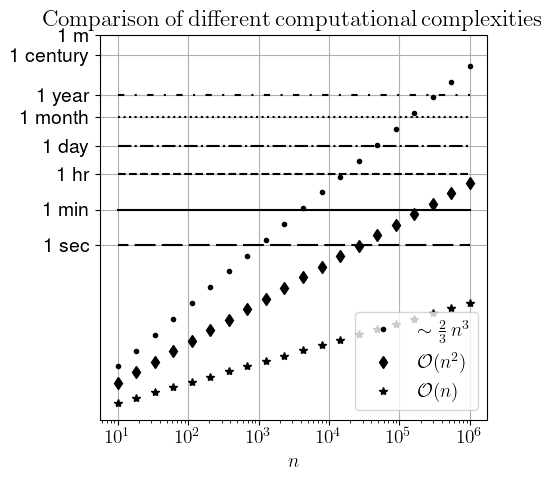

In [186]:
n = np.logspace(1,6,20)
# n = np.linspace(1,1e5,200)
plt.figure(figsize=(5,5))
plt.loglog(n,tauOpe*(2./3)*np.power(n,3),'k.',label=r'$\sim\frac{2}{3}\,n^3$')
plt.plot(n,tauOpe*np.power(n,2),'kd',label=r'$\mathcal{O}(n^2)$')
plt.plot(n,tauOpe*np.power(n,1),'k*',label=r'$\mathcal{O}(n)$')
plt.plot(n,1+n*0,color='k',linestyle=(5, (10, 3)))
plt.plot(n,60+n*0,color='k',linestyle='-')
plt.plot(n,60*60+n*0,color='k',linestyle='--')
plt.plot(n,60*60*24+n*0,color='k',linestyle='-.')
plt.plot(n,60*60*24*30+n*0,color='k',linestyle=':')
plt.plot(n,60*60*24*30*12+n*0,color='k',linestyle=(0, (3, 5, 1, 5)))
plt.yticks([1,60,60*60,60*60*24,60*60*24*30,60*60*24*30*12,60*60*24*30*12*100,60*60*24*30*12*1000],['1 sec','1 min','1 hr','1 day','1 month','1 year','1 century','1 m'])
plt.xlabel(r'$n$')
plt.title(r'$\mathrm{Comparison \, of \, different \, computational \, complexities}$')
plt.grid(True)
plt.legend(loc='best')
plt.show()